In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import cvxpy as cp

In [5]:
# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[-1.79109255e-19  2.85112420e-02  2.79973443e-19  3.37658729e-20
 -2.72802663e-19  1.49285011e-01 -9.94082533e-20  8.35373900e-20
  2.46718649e-01  5.78224144e-01 -4.03739463e-19  1.01242860e-03
 -9.28486180e-20  2.26767464e-01 -1.58813678e-19 -8.97232272e-20
 -1.22145729e-19 -1.51509428e-19  1.12060672e-19 -3.48318635e-19]
[ 2.50938945  0.          2.78354615  1.79425782 13.08579183  0.
  0.73716363  3.35344995  0.          0.          8.93825054  0.
  7.02955161  0.          4.71068649  3.18873635  2.06090107 10.08166738
  3.0481157   8.53268239]


In [6]:
def softmax(M, axis=-1):
    return cp.exp(M - cp.log(cp.sum(cp.exp(M), axis=axis, keepdims=True)))

def l1norm_agent(X, phi, b, u):
    """
    Params
    ------
    X : (d,)
    phi : (m,d)
    b : (m,)
    u : (m,)
    """
    d, = X.shape
    m, = b.shape
    one_m = np.ones(m)
    X_hat = cp.Variable(d)
    
    objective = cp.Maximize(u @ (phi @ X_hat + b) / (one_m @ (phi @ X_hat + b)) - 0.5 * cp.sum_squares(X - X_hat))
    constraints = [-X_hat <= 0]
    prob = cp.Problem(objective, constraints)#, constraints)
    result = prob.solve()#qcp=True)
    
    return X_hat.value

In [7]:
def lfp(A, b, c, d, alpha, beta):
    m, n = A.shape
    
    x = cp.Variable(n)
    objective = cp.Maximize((c @ x + alpha) / (d @ x + beta))
    constraints = [x >= 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(qcp=True)
    
    return x.value

In [8]:
m = 3
n = 2
A = np.random.rand(m, n)
b = np.random.rand(m)
c = np.random.rand(n)
d = np.random.rand(n)
alpha = np.random.rand()
beta = np.random.rand()

In [9]:
A, b, c, d, alpha, beta

(array([[0.68245371, 0.22820573],
        [0.01376751, 0.41672396],
        [0.93848189, 0.34302811]]),
 array([0.7797443 , 0.17473631, 0.34195284]),
 array([0.14459772, 0.71677081]),
 array([0.69930762, 0.68849732]),
 0.25339603448629966,
 0.6923601216234089)

In [10]:
# lfp(A, b, c, d, alpha, beta)

In [11]:
x = cp.Variable()
concave_fractional_fn = cp.sqrt(x) / cp.exp(x)
problem = cp.Problem(cp.Maximize(concave_fractional_fn))
assert problem.is_dqcp()
problem.solve(qcp=True)
x.value

array(0.50000165)

In [776]:
d = 2
m = 2
X = np.ones(d)
phi = np.ones((m, d))
b = np.ones(m)
u = np.ones(m)
one_m = np.ones(m)

In [777]:
u @ (phi @ X) / (one_m @ (phi @ X))

1.0

In [778]:
# l1norm_agent(X, phi, b, u)

In [779]:
import torch
from torch import nn

In [780]:
def criterion(X_hat, X, phi, b, u):
    m, = b.shape
    one_m = torch.ones(m)
    action = phi @ X_hat + b
    reward = u @ action / (one_m @ action)
    cost = torch.sum((X - X_hat) ** 2)
    return - (reward - 0.5 * cost)

In [781]:
X_hat = torch.tensor([1.] * d)
X = torch.tensor([2.] * d)
phi = torch.tensor(phi, dtype=torch.float32)
b = torch.tensor(b, dtype=torch.float32)
u = torch.tensor(u, dtype=torch.float32)

In [782]:
X_hat.requires_grad_(True)
optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)

In [783]:
optimizer.zero_grad()
loss = criterion(X_hat, X, phi, b, u)
loss.backward()
optimizer.step()
X_hat, loss

(tensor([1.0100, 1.0100], requires_grad=True),
 tensor(-0., grad_fn=<NegBackward0>))

In [903]:
def l1norm_gragent(X, phi, b, u):
    m, d = phi.shape
    one_m = torch.ones(m)
    X_hat = torch.rand(d)
    X_hat.requires_grad_(True)
    optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)
    for _ in range(300):
        optimizer.zero_grad()
        action = phi @ X_hat + b
        reward = u @ action / (one_m @ action)
        cost = torch.sum((X - X_hat) ** 2)
        loss = - (reward - 0.5 * cost)
        loss.backward()
        optimizer.step()
        # print(loss)
    return X_hat

def softmax_gragent(X, phi, b, u):
    m, d = phi.shape
    one_m = torch.ones(m)
    X_hat = torch.rand(d)
    X_hat.requires_grad_(True)
    softmax = nn.Softmax()
    optimizer = torch.optim.SGD([X_hat], lr=0.01, momentum=0.9)
    for _ in range(300):
        optimizer.zero_grad()
        reward = u @ softmax(phi @ X_hat + b)
        cost = torch.sum((X - X_hat) ** 2)
        loss = - (reward - 0.5 * cost)
        loss.backward()
        optimizer.step()
        # print(loss)
    return X_hat

def l1norm_decision_maker_criterion(Xs_hat, Xs, phi, b, W, u):
    Xs_hat = Xs_hat.T
    Xs = Xs.T
    d, m = W.shape
    one_m = torch.ones(m)
    action = phi @ Xs_hat + b.reshape(-1, 1) # md @ dn + m --> mn
    penalty = 0
    reward = X @ (W @ action / (one_m @ action)) # nd @ (dm @ mn / (m @ mn)) --> n
    for i in range(d):
        pen_i = Xs[i] * Xs_hat[i] # n
        for j in range(d):
            pen_i -= ((u @ phi[:, i]) * (one_m @ phi[:, j]) + (u @ phi[:, j]) * (one_m @ phi[:, i])) * Xs_hat[i] * Xs_hat[j]
        pen_i += 2 * Xs_hat[i] ** 2
        penalty -= pen_i ** 2
    # print(reward, penalty)
    return torch.sum(reward)
    

def l1norm_phi(Xs, W, u):
    d, m = W.shape
    # one_m = torch.ones(m)
    Xs_hat = Xs.clone()
    Xs_hat.requires_grad_(True)
    phi = torch.rand((m, d))
    phi.requires_grad_(True)
    b = torch.zeros(m)
    b.requires_grad_(True)
    optimizer = torch.optim.Adam([Xs_hat, phi, b], lr=0.0001)
    for _ in range(300):
        optimizer.zero_grad()
        loss = -l1norm_decision_maker_criterion(Xs_hat, Xs, phi, b, W, u)
        # print(loss)
        loss.backward()
        optimizer.step()
    return phi, b
    

In [905]:
l1norm_phi(Xs, W, u)

tensor([0.4115, 0.4050, 0.4071, 0.4052, 0.4169], grad_fn=<SqueezeBackward3>) tensor([-0.9453, -5.6546, -7.0174, -3.9155, -1.3345], grad_fn=<SubBackward0>)
tensor(-2.0457, grad_fn=<NegBackward0>)
tensor([0.4116, 0.4051, 0.4072, 0.4053, 0.4170], grad_fn=<SqueezeBackward3>) tensor([-0.9458, -5.6538, -7.0176, -3.9150, -1.3351], grad_fn=<SubBackward0>)
tensor(-2.0461, grad_fn=<NegBackward0>)
tensor([0.4117, 0.4051, 0.4072, 0.4054, 0.4171], grad_fn=<SqueezeBackward3>) tensor([-0.9462, -5.6529, -7.0179, -3.9145, -1.3357], grad_fn=<SubBackward0>)
tensor(-2.0464, grad_fn=<NegBackward0>)
tensor([0.4117, 0.4052, 0.4073, 0.4054, 0.4172], grad_fn=<SqueezeBackward3>) tensor([-0.9466, -5.6521, -7.0181, -3.9140, -1.3363], grad_fn=<SubBackward0>)
tensor(-2.0468, grad_fn=<NegBackward0>)
tensor([0.4118, 0.4052, 0.4073, 0.4055, 0.4173], grad_fn=<SqueezeBackward3>) tensor([-0.9470, -5.6513, -7.0183, -3.9135, -1.3369], grad_fn=<SubBackward0>)
tensor(-2.0472, grad_fn=<NegBackward0>)
tensor([0.4119, 0.4053, 0

tensor([0.4191, 0.4109, 0.4128, 0.4113, 0.4250], grad_fn=<SqueezeBackward3>) tensor([-0.9797, -5.5752, -7.0361, -3.8669, -1.3178], grad_fn=<SubBackward0>)
tensor(-2.0791, grad_fn=<NegBackward0>)
tensor([0.4192, 0.4110, 0.4129, 0.4114, 0.4251], grad_fn=<SqueezeBackward3>) tensor([-0.9799, -5.5743, -7.0362, -3.8664, -1.3167], grad_fn=<SubBackward0>)
tensor(-2.0795, grad_fn=<NegBackward0>)
tensor([0.4193, 0.4110, 0.4129, 0.4115, 0.4252], grad_fn=<SqueezeBackward3>) tensor([-0.9802, -5.5734, -7.0363, -3.8658, -1.3156], grad_fn=<SubBackward0>)
tensor(-2.0798, grad_fn=<NegBackward0>)
tensor([0.4193, 0.4111, 0.4130, 0.4115, 0.4252], grad_fn=<SqueezeBackward3>) tensor([-0.9804, -5.5726, -7.0364, -3.8653, -1.3144], grad_fn=<SubBackward0>)
tensor(-2.0802, grad_fn=<NegBackward0>)
tensor([0.4194, 0.4111, 0.4131, 0.4116, 0.4253], grad_fn=<SqueezeBackward3>) tensor([-0.9807, -5.5717, -7.0366, -3.8647, -1.3133], grad_fn=<SubBackward0>)
tensor(-2.0805, grad_fn=<NegBackward0>)
tensor([0.4195, 0.4112, 0

tensor(-2.1154, grad_fn=<NegBackward0>)
tensor([0.4274, 0.4173, 0.4190, 0.4179, 0.4342], grad_fn=<SqueezeBackward3>) tensor([-0.9819, -5.4803, -7.0366, -3.8059, -1.1991], grad_fn=<SubBackward0>)
tensor(-2.1158, grad_fn=<NegBackward0>)
tensor([0.4275, 0.4173, 0.4191, 0.4180, 0.4342], grad_fn=<SqueezeBackward3>) tensor([-0.9816, -5.4793, -7.0365, -3.8053, -1.1980], grad_fn=<SubBackward0>)
tensor(-2.1161, grad_fn=<NegBackward0>)
tensor([0.4276, 0.4174, 0.4191, 0.4181, 0.4343], grad_fn=<SqueezeBackward3>) tensor([-0.9813, -5.4783, -7.0364, -3.8046, -1.1969], grad_fn=<SubBackward0>)
tensor(-2.1165, grad_fn=<NegBackward0>)
tensor([0.4276, 0.4175, 0.4192, 0.4181, 0.4344], grad_fn=<SqueezeBackward3>) tensor([-0.9810, -5.4774, -7.0363, -3.8040, -1.1958], grad_fn=<SubBackward0>)
tensor(-2.1168, grad_fn=<NegBackward0>)
tensor([0.4277, 0.4175, 0.4192, 0.4182, 0.4345], grad_fn=<SqueezeBackward3>) tensor([-0.9807, -5.4764, -7.0361, -3.8033, -1.1946], grad_fn=<SubBackward0>)
tensor(-2.1172, grad_fn=<

(tensor([[0.2816, 0.4512],
         [0.7196, 0.8424]], requires_grad=True),
 tensor([ 0.0297, -0.0313], requires_grad=True))

In [853]:
X = torch.rand(d)
phi = torch.rand((m, d))
b = torch.zeros(m)
X, softmax_gragent(X, phi, b, u)

C:\Users\Alex\AppData\Local\Temp\ipykernel_39092\828025484.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  reward = u @ softmax(phi @ X_hat + b)


(tensor([0.7010, 0.8703]), tensor([0.7142, 0.8769], requires_grad=True))

In [821]:
def classify(X, phi, b):
    m, d = phi.shape
    one_m = torch.ones(m, dtype=torch.float64)
    action = phi @ X + b
    return action / (one_m @ action)

In [822]:
# classify(X, phi, b), classify(X_hat, phi, b)

In [834]:
true_phi, true_b

(tensor([[0.5595, 0.0952],
         [0.1264, 0.7859]]),
 tensor([0., 0.]))

In [ ]:
true_phi = torch.rand((m, d))
true_b = torch.zeros(m)

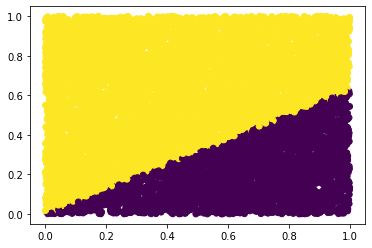

In [833]:
X_x = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X_y = [np.random.uniform(low=0, high=1) for _ in range(10_000)]
X = np.array([X_x, X_y]).T
Y = [torch.argmax(classify(x, true_phi, true_b)).item() for x in X]
plt.scatter(X_x, X_y, c=Y)

C:\Users\Alex\AppData\Local\Temp\ipykernel_39092\828025484.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  reward = u @ softmax(phi @ X_hat + b)


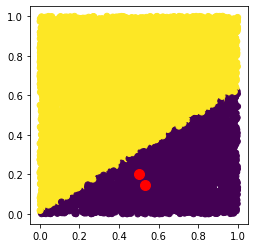

In [861]:
x_new = torch.tensor([0.5, 0.2])
u = torch.tensor([0.3, 0])
x_prime = softmax_gragent(x_new, true_phi, true_b, u).detach()

plt.gca().set_aspect('equal')
plt.scatter(X_x, X_y, c=Y)
plt.plot(x_new[0], x_new[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(x_prime[0], x_prime[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")

In [860]:
x_prime

tensor([0.5216, 0.1656])

In [870]:
fake_phi = torch.rand(2,2)
fake_phi.requires_grad_(True)
res = torch.sum(fake_phi + fake_phi[:,1] * 2)
res

tensor(5.3704, grad_fn=<SumBackward0>)

In [871]:
res.backward()

In [878]:
n = 5
Xs = torch.rand((n, d))
W = torch.rand((d, m))

In [880]:
l1norm_phi(Xs, W, u)

RuntimeError: The size of tensor a (5) must match the size of tensor b (2) at non-singleton dimension 1

In [886]:
phi @ Xs.T + b.reshape(-1, 1)

tensor([[0.4646, 0.8714, 0.9069, 0.7962, 0.3983],
        [0.3173, 0.5402, 0.5802, 0.4952, 0.2943]])